# Predict Average Bunker Score

Preidcts the average score for each bunker solely based on the sentiment analysis of the text in each review.

### 1. Imports

In [2]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


### 2: File paths

In [3]:
data_path = "../../data/processed/processed_bunker_sentiment.pkl"
model_path = "../outputs_final/bunker_multi_class/final_model"

### 3: Load and filter data

In [4]:
df = pd.read_pickle(data_path)
bunker_counts = df["bunker_name"].value_counts()
valid_bunkers = bunker_counts[bunker_counts >= 100].index
df = df[df["bunker_name"].isin(valid_bunkers)].copy()
print(f"Filtered to {len(valid_bunkers)} bunkers with >= 100 reviews")

Filtered to 6 bunkers with >= 100 reviews


### 4: Load model and tokenizer

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # or "bert-base-cased"
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Detect device: prioritize MPS, fallback to CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)
print(f"Using device: {device}")

Using device: mps


### 5. Prediction function

In [6]:
def predict_sentiment_batch(token_batch):
    input_ids = torch.tensor([x["input_ids"] for x in token_batch]).to(device)
    attention_mask = torch.tensor([x["attention_mask"] for x in token_batch]).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
    
    return preds.cpu().tolist()


### 6: Predict in batches

In [7]:
batch_size = 32
tokens = df["tokens"].tolist()
predictions = []

for i in tqdm(range(0, len(tokens), batch_size)):
    batch = tokens[i:i+batch_size]
    preds = predict_sentiment_batch(batch)
    predictions.extend(preds)

  0%|          | 0/435 [00:00<?, ?it/s]

100%|██████████| 435/435 [29:09<00:00,  4.02s/it]


### 7. Add predictions to dataframe

In [8]:
df["predicted_label"] = predictions
label_to_score = {0: -1, 1: 0, 2: 1}
df["sentiment_score"] = df["predicted_label"].map(label_to_score)

### 8. Aggregate scores per bunker

In [9]:
bunker_scores = df.groupby("bunker_name")["sentiment_score"].mean().reset_index()
bunker_scores = bunker_scores.sort_values(by="sentiment_score", ascending=False)
bunker_scores.head()

,bunker_name,sentiment_score
0,betasom,0.798627
3,larochelle_museum,0.756854
1,hamburg,0.744902
2,keromann,0.735960
5,valentine,0.728178


### 9: Save results

In [10]:
output_path = "../../data/processed/bunker_sentiment_ranking.csv"
bunker_scores.to_csv(output_path, index=False)
print(f"Saved bunker sentiment ranking to: {output_path}")

Saved bunker sentiment ranking to: ../../data/processed/bunker_sentiment_ranking.csv


### 10. Distribution of Average Sentiment Scores Across Bunkers

/var/folders/g6/rpqlqh_142q2yhdtrkhh5jnh0000gn/T/ipykernel_62745/1071785172.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=merged, x="bunker_name_formatted", y="sentiment_score", palette="coolwarm")
/var/folders/g6/rpqlqh_142q2yhdtrkhh5jnh0000gn/T/ipykernel_62745/1071785172.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
/var/folders/g6/rpqlqh_142q2yhdtrkhh5jnh0000gn/T/ipykernel_62745/1071785172.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y:.1f}" for y in ax.get_yticks()], fontweight='bold')


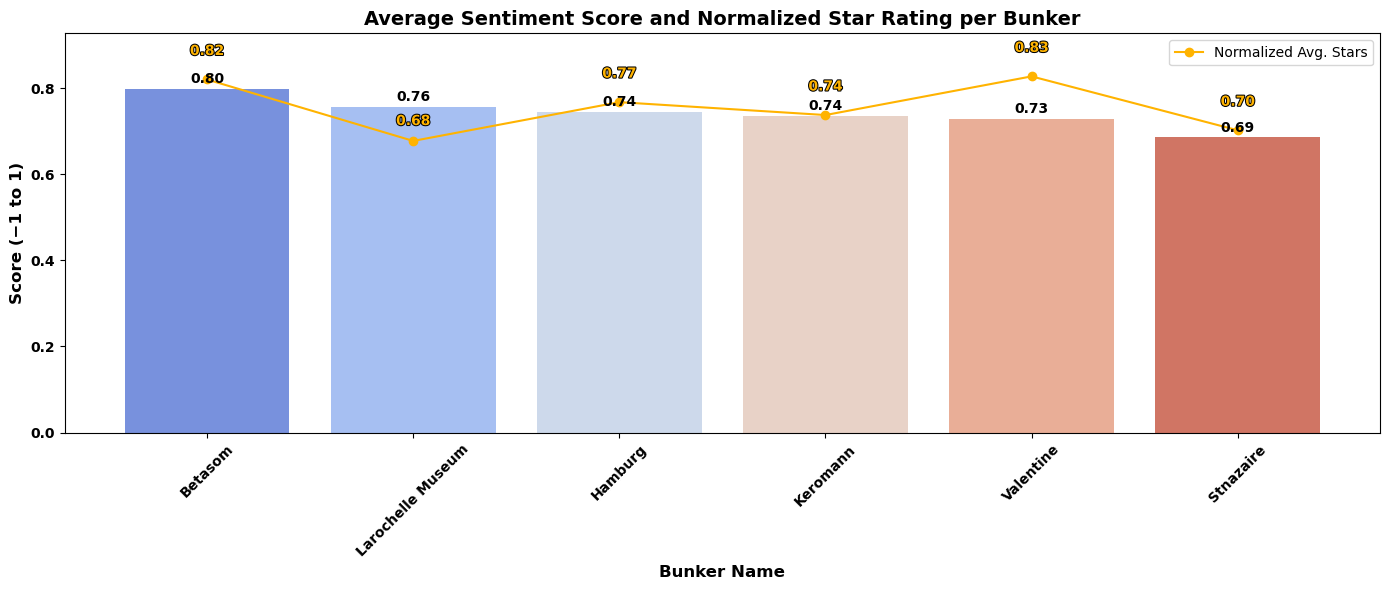

In [33]:
# Set ymin to 0 since all scores are positive
ymin = 0
ymax = max(merged["sentiment_score"].max(), merged["normalized_stars"].max()) + 0.1

# Format bunker names
merged["bunker_name_formatted"] = merged["bunker_name"].str.replace('_', ' ').str.title()

# Manual corrections
merged["bunker_name_formatted"] = merged["bunker_name_formatted"].replace({
    "Stnazire": "St. Nazaire"
})

# Plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(data=merged, x="bunker_name_formatted", y="sentiment_score", palette="coolwarm")

# Better yellow line
line_color = "#FFB300"
x_positions = ax.get_xticks()
ax.plot(x_positions, merged["normalized_stars"], color=line_color, marker="o", linestyle='-', label="Normalized Avg. Stars")

# Line labels
import matplotlib.patheffects as path_effects

for x, y in zip(x_positions, merged["normalized_stars"]):
    offset = 0.03 if y < 0.69 else 0.05  # Less vertical spacing if score is below 0.69
    txt = ax.text(
        x, y + offset, f"{y:.2f}",
        ha='center', va='bottom',
        fontsize=10, fontweight='bold',
        color=line_color
    )
    txt.set_path_effects([
        path_effects.Stroke(linewidth=1.5, foreground='black'),
        path_effects.Normal()
    ])



# Bar value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10, padding=2, fontweight='bold')

# Styling
plt.title("Average Sentiment Score and Normalized Star Rating per Bunker", fontsize=14, fontweight='bold')
ax.set_ylabel("Score (−1 to 1)", fontsize=12, fontweight='bold')  
ax.set_xlabel("Bunker Name", fontsize=12, fontweight='bold')
ax.set_ylim(ymin, ymax)

# Bold tick labels
ax.tick_params(axis='x', labelrotation=45, labelsize=10)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')
ax.tick_params(axis='y', labelsize=10)
ax.set_yticklabels([f"{y:.1f}" for y in ax.get_yticks()], fontweight='bold')

# Legend
ax.legend(loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_pickle("path/to/processed_bunker_sentiment.pkl")

# Choose one bunker and filter negative reviews
example_bunker = "Some Bunker Name"  # Replace with actual bunker name
bunker_df = df[(df["bunker_name"] == example_bunker) & (df["predicted_label"] == 0)].copy()

# Sample to reduce memory usage
sample_texts = bunker_df["clean_text"].dropna().sample(n=100, random_state=42).tolist()

# Load spaCy
import en_core_web_sm
nlp = en_core_web_sm.load()

# Extract noun phrases
phrases = []
for doc in nlp.pipe(sample_texts, disable=["ner", "parser"]):
    phrases.extend([chunk.text.lower().strip() for chunk in doc.noun_chunks])

# Count and plot top complaint phrases
phrase_counts = Counter(phrases).most_common(15)
common_df = pd.DataFrame(phrase_counts, columns=["phrase", "count"])

plt.figure(figsize=(10, 6))
sns.barplot(data=common_df, y="phrase", x="count", palette="Reds_d")
plt.title(f"Top Complaint Phrases in Negative Reviews for '{example_bunker}'")
plt.xlabel("Frequency")
plt.ylabel("Phrase")
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'spacy'